Loading Data...
✅ Found: Birth Date='b3_01', Place of Delivery='m15_1', District='sdistrict'
Analyzing 1500 births in the Eastern Province...

--- Summary Results: Health Facility Delivery % ---
                   Val
Location              
Rwamagana           97
Nyagatare           86
Gatsibo             95
Kayonza             90
Kirehe              94
Ngoma               95
Bugesera            92
East Province       92
Rwanda (National)   93
✅ Analysis Complete. eastern_facility_delivery_final.json


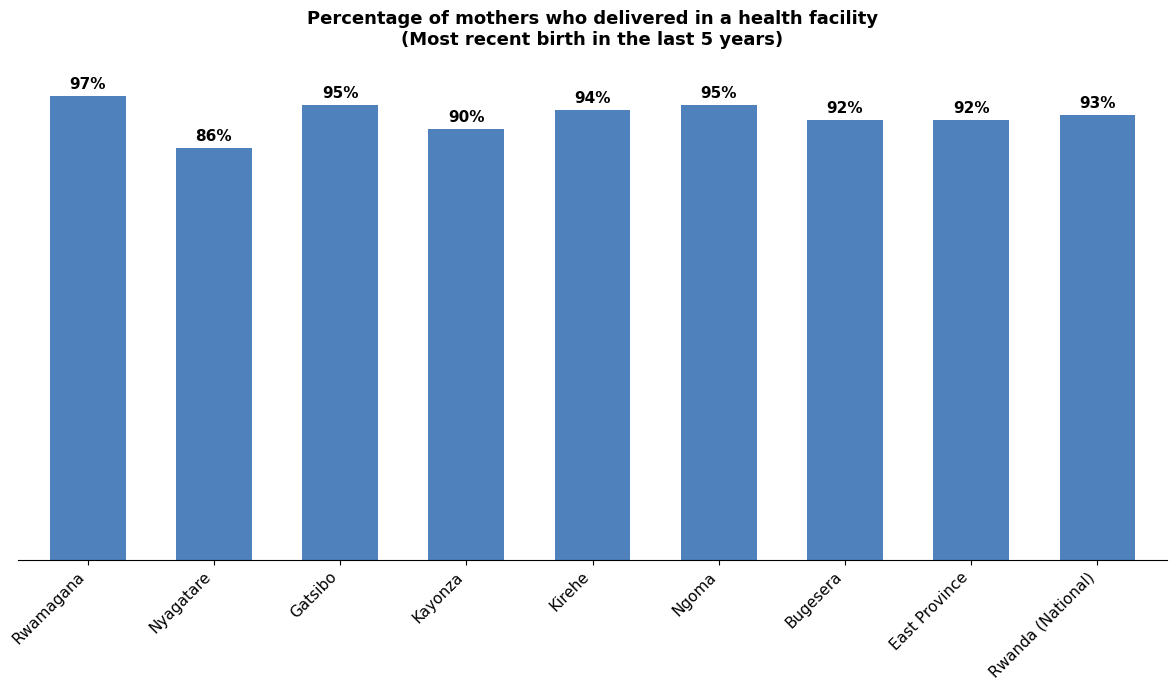

In [1]:
#!/usr/bin/env python3
# dhs_health_facility_delivery_final.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import math

# ------------------------------------------------------------------
# 1. SETTINGS
# ------------------------------------------------------------------
DATA_DIR = "data"
FILE_PATH = os.path.join(DATA_DIR, "RWIR81FL.DTA")

DIST_MAP = {
    51: 'Rwamagana', 52: 'Nyagatare', 53: 'Gatsibo',
    54: 'Kayonza', 55: 'Kirehe', 56: 'Ngoma', 57: 'Bugesera'
}

# ------------------------------------------------------------------
# 2. CALCULATION HELPERS
# ------------------------------------------------------------------
def standard_round(n):
    return int(math.floor(n + 0.5))

def get_facility_pct(df):
    if df.empty or 'w' not in df.columns or df['w'].sum() == 0:
        return 0
    # Facility codes in DHS are 20-39
    is_fac = ((df['m_val'] >= 20) & (df['m_val'] <= 39)).astype(int)
    raw_pct = np.average(is_fac, weights=df['w']) * 100
    return standard_round(raw_pct)

# ------------------------------------------------------------------
# 3. ANALYSIS PIPELINE
# ------------------------------------------------------------------
if __name__ == "__main__":
    if not os.path.exists(FILE_PATH):
        print(f"❌ Error: {FILE_PATH} not found."); exit()

    print("Loading Data...")
    df = pd.read_stata(FILE_PATH, convert_categoricals=False)
    df.columns = df.columns.str.lower()

    # --- AGGRESSIVE COLUMN DETECTION ---
    # b3: Birth date (usually b3_01)
    # m_col: Place of delivery (can be m3_1 or m15_1)
    b3_col = next((c for c in df.columns if c in ['b3_01', 'b3_1', 'b3$01']), None)
    
    # Check for m3 first, then m15 (Place of Delivery)
    m_col = next((c for c in df.columns if c in ['m3_1', 'm3_01', 'm15_1', 'm15_01']), None)
    
    # If still not found, search for any m15 or m3 prefix
    if not m_col:
        m_col = next((c for c in df.columns if c.startswith('m15_') or c.startswith('m3_')), None)

    dist_col = next((c for c in ['sdistrict', 'sdstr', 'sdist', 'v001'] if c in df.columns), None)

    if not b3_col or not m_col:
        print("\n❌ Error: Critical columns not found.")
        print(f"Required: Birth Date (b3) and Place of Delivery (m3 or m15).")
        print(f"Available 'm' columns: {[c for c in df.columns if c.startswith('m')][:10]}")
        exit()

    print(f"✅ Found: Birth Date='{b3_col}', Place of Delivery='{m_col}', District='{dist_col}'")

    # --- CREATE CLEAN WORKSET ---
    # We only pull the specific columns we found to avoid KeyError
    needed = [b3_col, m_col, 'v005', 'v008', 'v024']
    if dist_col: needed.append(dist_col)
    
    work_df = df[needed].copy()

    # Convert to numeric safely
    for col in work_df.columns:
        work_df[col] = pd.to_numeric(work_df[col], errors='coerce').fillna(0)

    # Standardize names for calculation
    work_df['b_val'] = work_df[b3_col]
    work_df['m_val'] = work_df[m_col]
    work_df['w'] = work_df['v005'] / 1000000.0

    # --- FILTERS ---
    # Last birth in 5 years (60 months)
    work_df = work_df[(work_df['v008'] - work_df['b_val']) < 60].copy()
    
    if work_df.empty:
        print("❌ Error: No births found in the 5-year window."); exit()

    # --- AGGREGATION ---
    results = {}
    df_east = work_df[work_df['v024'] == 5].copy()
    
    print(f"Analyzing {len(df_east)} births in the Eastern Province...")

    for code, name in DIST_MAP.items():
        subset = df_east[df_east[dist_col] == code]
        results[name] = get_facility_pct(subset)

    # Totals
    results["East Province"] = get_facility_pct(df_east)
    results["Rwanda (National)"] = get_facility_pct(work_df)

    # DataFrame
    final_df = pd.DataFrame(list(results.items()), columns=["Location", "Val"]).set_index("Location")
    print("\n--- Summary Results: Health Facility Delivery % ---")
    print(final_df)

    # --- JSON OUTPUT ---
    json_name = "eastern_facility_delivery_final.json"
    with open(json_name, "w") as f:
        json.dump(final_df["Val"].to_dict(), f, indent=4)

    # --- PLOTTING ---
    colors = ["#4F81BD"] * 7 + ["#00B050", "#ED7D31"]
    ax = final_df.plot(kind="bar", color=colors, figsize=(12, 7), width=0.6, legend=False)
    
    plt.title("Percentage of mothers who delivered in a health facility\n(Most recent birth in the last 5 years)", 
              fontsize=13, fontweight="bold", pad=20)
    plt.xticks(rotation=45, ha='right', fontsize=11)
    plt.xlabel("")
    ax.yaxis.set_visible(False)
    for s in ["top", "right", "left"]: ax.spines[s].set_visible(False)
    
    for c in ax.containers:
        ax.bar_label(c, fmt='%d%%', padding=3, fontsize=11, fontweight="bold")
    
    plt.tight_layout()
    plt.savefig("Health_Facility_Delivery.png", dpi=300)
    print(f"✅ Analysis Complete. {json_name}")